## Análisis de ocupación de rutas ## 

In [144]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import holidays
import requests
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
import os
print(os.getcwd())

c:\Users\juani\OneDrive\Escritorio\Data Scientist\CARREER\PROYECTO TRANSPORTE


In [147]:
df = pd.read_excel('RECORRIDOS_2025_01-08_UNIDOS.xlsx', sheet_name='Sheet1')

In [ ]:
print(df.head())

        FECHA DIA DE LA SEMANA      HORA  CLIMA   PLACA  PAS.REG  PAS.ESP  \
0  01-01-2025        miércoles  11:45:00    NaN  STQ296        9        0   
1  01-01-2025        miércoles  14:30:00    NaN  STQ296        3        5   
2  04-01-2025           sábado  09:35:00    NaN  STQ296        9        0   
3  04-01-2025           sábado  12:40:00    NaN  STQ296        9        0   
4  06-01-2025            lunes  08:00:00    NaN  STQ296        8        0   

   % OCUPACION  
0     1.000000  
1     0.888889  
2     1.000000  
3     1.000000  
4     0.888889  


In [148]:
# Copia de trabajo (para no tocar el original en memoria)
data = df.copy()

In [149]:
# Normalizar FECHA y HORA y crear timestamp de salida
data["FECHA"] = pd.to_datetime(data["FECHA"], dayfirst=True, errors="coerce").dt.date
# Asegurar HORA como texto HH:MM:SS y luego a time
data["HORA"] = pd.to_datetime(data["HORA"].astype(str), errors="coerce").dt.time

C:\Users\juani\AppData\Local\Temp\ipykernel_16772\3289071719.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["HORA"] = pd.to_datetime(data["HORA"].astype(str), errors="coerce").dt.time


In [150]:
# Crear un objeto con los festivos de Colombia para 2025
col_holidays = holidays.Colombia(years=[2025])

# Suponiendo que tu columna FECHA ya está en formato datetime
data["FECHA"] = pd.to_datetime(data["FECHA"], dayfirst=True, errors="coerce")

# Marcar si cada fecha es festivo
data["FESTIVO"] = data["FECHA"].dt.date.isin(col_holidays).map({True: "Sí", False: "No"})

In [151]:
print(data.head())

       FECHA DIA DE LA SEMANA      HORA  CLIMA   PLACA  PAS.REG  PAS.ESP  \
0 2025-01-01        miércoles  11:45:00    NaN  STQ296        9        0   
1 2025-01-01        miércoles  14:30:00    NaN  STQ296        3        5   
2 2025-01-04           sábado  09:35:00    NaN  STQ296        9        0   
3 2025-01-04           sábado  12:40:00    NaN  STQ296        9        0   
4 2025-01-06            lunes  08:00:00    NaN  STQ296        8        0   

   % OCUPACION FESTIVO  
0     1.000000      Sí  
1     0.888889      Sí  
2     1.000000      No  
3     1.000000      No  
4     0.888889      Sí  


In [152]:
# Si FECHA es string o datetime, conviértela solo una vez:
data["FECHA"] = pd.to_datetime(data["FECHA"], dayfirst=True, errors="coerce")

# Si la necesitas como date puro (no recomendado para merges con horas):
# data["FECHA"] = data["FECHA"].dt.date
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4639 entries, 0 to 4638
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4630 non-null   datetime64[ns]
 1   DIA DE LA SEMANA  4639 non-null   object        
 2   HORA              4630 non-null   object        
 3   CLIMA             0 non-null      float64       
 4   PLACA             4630 non-null   object        
 5   PAS.REG           4639 non-null   int64         
 6   PAS.ESP           4639 non-null   int64         
 7   % OCUPACION       4639 non-null   float64       
 8   FESTIVO           4639 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 326.3+ KB
       FECHA DIA DE LA SEMANA      HORA  CLIMA   PLACA  PAS.REG  PAS.ESP  \
0 2025-01-01        miércoles  11:45:00    NaN  STQ296        9        0   
1 2025-01-01        miércoles  14:30:00    NaN  STQ296        3  

In [153]:
# Dejar solo la fecha sin hora
data["FECHA"] = data["FECHA"].dt.date

In [ ]:
# Exportar el DataFrame con festivos a un archivo Excel
data.to_excel("RECORRIDOS_2025_01-08_UNIDOS.xlsx", index=False)

## Ahora vamos a buscar el estado del clima durante el 1 de enero al 31 de agosto de 2025 ##

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 5.0689,
	"longitude": -75.5174,
	"start_date": "2025-01-01",
	"end_date": "2025-08-31",
	"hourly": ["temperature_2m", "weather_code"],
	"models": "best_match",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["weather_code"] = hourly_weather_code

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 5.125°N -75.5°E
Elevation: 2120.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                           date  temperature_2m  weather_code
0    2025-01-01 00:00:00+00:00       15.983500          45.0
1    2025-01-01 01:00:00+00:00       15.883500           3.0
2    2025-01-01 02:00:00+00:00       15.783500           3.0
3    2025-01-01 03:00:00+00:00       15.533500          45.0
4    2025-01-01 04:00:00+00:00       15.533500          45.0
...                        ...             ...           ...
5827 2025-08-31 19:00:00+00:00       27.683500           3.0
5828 2025-08-31 20:00:00+00:00       26.683500          80.0
5829 2025-08-31 21:00:00+00:00       25.383501          95.0
5830 2025-08-31 22:00:00+00:00       23.933500          95.0
5831 2025-08-31 23:00:00+00:00       23.033501          80.0

[5832 rows x 3 columns]


In [ ]:
# Convertir la columna 'date' a datetime
hourly_dataframe["date"] = pd.to_datetime(hourly_dataframe["date"])

# Crear columnas separadas
hourly_dataframe["Fecha"] = hourly_dataframe["date"].dt.date
hourly_dataframe["Hora"] = hourly_dataframe["date"].dt.time
hourly_dataframe["Hora_num"] = hourly_dataframe["date"].dt.hour

# Eliminar la columna original 'date'
hourly_dataframe = hourly_dataframe.drop(columns=["date"])

# Reorganizar columnas en el orden solicitado
column_order = ["Fecha", "Hora", "Hora_num", "temperature_2m", "weather_code"]
hourly_dataframe = hourly_dataframe[column_order]

print(hourly_dataframe.head())

        Fecha      Hora  Hora_num  temperature_2m  weather_code
0  2025-01-01  00:00:00         0         15.9835          45.0
1  2025-01-01  01:00:00         1         15.8835           3.0
2  2025-01-01  02:00:00         2         15.7835           3.0
3  2025-01-01  03:00:00         3         15.5335          45.0
4  2025-01-01  04:00:00         4         15.5335          45.0


In [ ]:
# Exportar el DataFrame con festivos a un archivo Excel
hourly_dataframe.to_excel("clima_por_dias_horas_v2.xlsx", index=False)

## Combinación de los datasets que organizamos

Ahora se combinan los dos datasets por las variables de fecha y hora, teniendo en cuenta que para evitar muchos espacios en blanco por la hora vamos a realizar una aproximanción 

In [ ]:
# Convertir a datetime combinando fecha y hora
data["datetime"] = pd.to_datetime(data["FECHA"].astype(str) + " " + data["HORA"].astype(str), errors="coerce")
hourly_dataframe["datetime"] = pd.to_datetime(hourly_dataframe["Fecha"].astype(str) + " " + hourly_dataframe["Hora"].astype(str), errors="coerce")

# Eliminar filas con datetime nulo en ambos DataFrames antes del merge
data = data.dropna(subset=["datetime"])
hourly_dataframe = hourly_dataframe.dropna(subset=["datetime"])

# Ordenar (requisito para merge_asof)
data = data.sort_values("datetime")
hourly_dataframe = hourly_dataframe.sort_values("datetime")

# Hacer merge aproximado: busca la hora más cercana dentro de un margen (ej: 30 minutos)
df_merge = pd.merge_asof(
    data,
    hourly_dataframe,
    on="datetime",
    direction="nearest",          # Busca el valor más cercano
    tolerance=pd.Timedelta("5m") # Máxima diferencia aceptada
)

# Revisar resultado
print(df_merge.head())

        FECHA DIA DE LA SEMANA      HORA  CLIMA   PLACA  PAS.REG  PAS.ESP  \
0  2025-01-01        miércoles  09:00:00    NaN  STQ112        6        2   
1  2025-01-01        miércoles  09:00:00    NaN  STQ343        4        4   
2  2025-01-01        miércoles  11:00:00    NaN  STQ112        7        1   
3  2025-01-01        miércoles  11:45:00    NaN  STQ296        9        0   
4  2025-01-01        miércoles  12:45:00    NaN  STQ343        7        2   

   % OCUPACION FESTIVO            datetime       Fecha      Hora  Hora_num  \
0     0.888889      Sí 2025-01-01 09:00:00  2025-01-01  09:00:00       9.0   
1     0.888889      Sí 2025-01-01 09:00:00  2025-01-01  09:00:00       9.0   
2     0.888889      Sí 2025-01-01 11:00:00  2025-01-01  11:00:00      11.0   
3     1.000000      Sí 2025-01-01 11:45:00         NaN       NaN       NaN   
4     1.000000      Sí 2025-01-01 12:45:00         NaN       NaN       NaN   

   temperature_2m  weather_code  
0       14.533500           2.0  


In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4630 non-null   object        
 1   DIA DE LA SEMANA  4630 non-null   object        
 2   HORA              4630 non-null   object        
 3   CLIMA             0 non-null      float64       
 4   PLACA             4630 non-null   object        
 5   PAS.REG           4630 non-null   int64         
 6   PAS.ESP           4630 non-null   int64         
 7   % OCUPACION       4630 non-null   float64       
 8   FESTIVO           4630 non-null   object        
 9   datetime          4630 non-null   datetime64[ns]
 10  Fecha             2073 non-null   object        
 11  Hora              2073 non-null   object        
 12  Hora_num          2073 non-null   float64       
 13  temperature_2m    2073 non-null   float32       
 14  weather_code      2073 n

In [ ]:
# Exportar el DataFrame combinado a un archivo Excel
df_merge.to_excel("TABLA_COMPLETA.xlsx", index=False)

In [ ]:
df_merge["temperature_2m"] = df_merge["temperature_2m"].interpolate(method="linear")

In [ ]:
df_merge.info()
df_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4630 non-null   object        
 1   DIA DE LA SEMANA  4630 non-null   object        
 2   HORA              4630 non-null   object        
 3   CLIMA             0 non-null      float64       
 4   PLACA             4630 non-null   object        
 5   PAS.REG           4630 non-null   int64         
 6   PAS.ESP           4630 non-null   int64         
 7   % OCUPACION       4630 non-null   float64       
 8   FESTIVO           4630 non-null   object        
 9   datetime          4630 non-null   datetime64[ns]
 10  Fecha             2073 non-null   object        
 11  Hora              2073 non-null   object        
 12  Hora_num          2073 non-null   float64       
 13  temperature_2m    4630 non-null   float32       
 14  weather_code      2073 n

,FECHA,DIA DE LA SEMANA,HORA,CLIMA,PLACA,PAS.REG,PAS.ESP,% OCUPACION,FESTIVO,datetime,Fecha,Hora,Hora_num,temperature_2m,weather_code
0,2025-01-01,miércoles,09:00:00,NaN,STQ112,6,2,0.888889,Sí,2025-01-01 09:00:00,2025-01-01,09:00:00,9.0,14.533500,2.0
1,2025-01-01,miércoles,09:00:00,NaN,STQ343,4,4,0.888889,Sí,2025-01-01 09:00:00,2025-01-01,09:00:00,9.0,14.533500,2.0
2,2025-01-01,miércoles,11:00:00,NaN,STQ112,7,1,0.888889,Sí,2025-01-01 11:00:00,2025-01-01,11:00:00,11.0,14.183499,1.0
3,2025-01-01,miércoles,11:45:00,NaN,STQ296,9,0,1.000000,Sí,2025-01-01 11:45:00,NaN,NaN,NaN,15.183499,NaN
4,2025-01-01,miércoles,12:45:00,NaN,STQ343,7,2,1.000000,Sí,2025-01-01 12:45:00,NaN,NaN,NaN,16.183500,NaN


In [ ]:
df_merge["datetime_redondeada"] = df_merge["datetime"].dt.round("H")

C:\Users\juani\AppData\Local\Temp\ipykernel_16772\50991605.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_merge["datetime_redondeada"] = df_merge["datetime"].dt.round("H")


In [ ]:
df_merge_v2 = df_merge.merge(
    hourly_dataframe,
    left_on="datetime_redondeada",
    right_on="datetime",
    how="left"
)

In [ ]:
df_merge.info()
df_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                4630 non-null   object        
 1   DIA DE LA SEMANA     4630 non-null   object        
 2   HORA                 4630 non-null   object        
 3   CLIMA                0 non-null      float64       
 4   PLACA                4630 non-null   object        
 5   PAS.REG              4630 non-null   int64         
 6   PAS.ESP              4630 non-null   int64         
 7   % OCUPACION          4630 non-null   float64       
 8   FESTIVO              4630 non-null   object        
 9   datetime             4630 non-null   datetime64[ns]
 10  Fecha                2073 non-null   object        
 11  Hora                 2073 non-null   object        
 12  Hora_num             2073 non-null   float64       
 13  temperature_2m       4630 non-nul

,FECHA,DIA DE LA SEMANA,HORA,CLIMA,PLACA,PAS.REG,PAS.ESP,% OCUPACION,FESTIVO,datetime,Fecha,Hora,Hora_num,temperature_2m,weather_code,datetime_redondeada
0,2025-01-01,miércoles,09:00:00,NaN,STQ112,6,2,0.888889,Sí,2025-01-01 09:00:00,2025-01-01,09:00:00,9.0,14.533500,2.0,2025-01-01 09:00:00
1,2025-01-01,miércoles,09:00:00,NaN,STQ343,4,4,0.888889,Sí,2025-01-01 09:00:00,2025-01-01,09:00:00,9.0,14.533500,2.0,2025-01-01 09:00:00
2,2025-01-01,miércoles,11:00:00,NaN,STQ112,7,1,0.888889,Sí,2025-01-01 11:00:00,2025-01-01,11:00:00,11.0,14.183499,1.0,2025-01-01 11:00:00
3,2025-01-01,miércoles,11:45:00,NaN,STQ296,9,0,1.000000,Sí,2025-01-01 11:45:00,NaN,NaN,NaN,15.183499,NaN,2025-01-01 12:00:00
4,2025-01-01,miércoles,12:45:00,NaN,STQ343,7,2,1.000000,Sí,2025-01-01 12:45:00,NaN,NaN,NaN,16.183500,NaN,2025-01-01 13:00:00


In [160]:
df_merge_v2.to_excel("TABLA_COMPLETA_V2.xlsx", index=False)

In [165]:
print(df_merge_v2.columns)

Index(['FECHA', 'DIA DE LA SEMANA', 'HORA', 'CLIMA', 'PLACA', 'PAS.REG',
       'PAS.ESP', '% OCUPACION', 'FESTIVO', 'datetime_x', 'Fecha_x', 'Hora_x',
       'Hora_num_x', 'temperature_2m_x', 'weather_code_x',
       'datetime_redondeada', 'Fecha_y', 'Hora_y', 'Hora_num_y',
       'temperature_2m_y', 'weather_code_y', 'datetime_y'],
      dtype='object')


In [166]:
cols_keep = [
    "Fecha_y", "DIA DE LA SEMANA", "FESTIVO", "Hora_y", "Hora_num_y",
    "weather_code_y", "CLIMA", "temperature_2m_y", "PLACA", "PAS.REG", "PAS.ESP", "% OCUPACION"
]
final_data = df_merge_v2[cols_keep]

final_data.info()
final_data.head()

# Guardar archivo limpio
final_data.to_excel("TABLA_FINAL.xlsx", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_y           4630 non-null   object 
 1   DIA DE LA SEMANA  4630 non-null   object 
 2   FESTIVO           4630 non-null   object 
 3   Hora_y            4630 non-null   object 
 4   Hora_num_y        4630 non-null   int32  
 5   weather_code_y    4630 non-null   float32
 6   CLIMA             0 non-null      float64
 7   temperature_2m_y  4630 non-null   float32
 8   PLACA             4630 non-null   object 
 9   PAS.REG           4630 non-null   int64  
 10  PAS.ESP           4630 non-null   int64  
 11  % OCUPACION       4630 non-null   float64
dtypes: float32(2), float64(2), int32(1), int64(2), object(5)
memory usage: 379.9+ KB


In [168]:
mapa_clima = {
    0: "Despejado",
    1: "Principalmente despejado",
    2: "Parcialmente nublado",
    3: "Nublado",
    45: "Niebla",
    48: "Niebla con escarcha",
    51: "Llovizna ligera",
    53: "Llovizna moderada",
    55: "Llovizna densa",
    61: "Lluvia ligera",
    63: "Lluvia moderada",
    65: "Lluvia fuerte",
    71: "Nieve ligera",
    73: "Nieve moderada",
    75: "Nieve fuerte",
    77: "Granos de nieve",
    80: "Chubascos ligeros",
    81: "Chubascos moderados",
    82: "Chubascos violentos",
    85: "Chubascos de nieve ligeros",
    86: "Chubascos de nieve fuertes",
    95: "Tormenta eléctrica",
    96: "Tormenta con granizo ligero",
    99: "Tormenta con granizo fuerte"
}

In [169]:
# Mapear los códigos al texto
final_data["CLIMA"] = final_data["weather_code_y"].map(mapa_clima)

# Si quedan valores nulos porque no hay código, rellenar
final_data["CLIMA"] = final_data["CLIMA"].fillna("Sin información")


C:\Users\juani\AppData\Local\Temp\ipykernel_16772\3761552894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data["CLIMA"] = final_data["weather_code_y"].map(mapa_clima)
C:\Users\juani\AppData\Local\Temp\ipykernel_16772\3761552894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data["CLIMA"] = final_data["CLIMA"].fillna("Sin información")


In [170]:
final_data.info()
final_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_y           4630 non-null   object 
 1   DIA DE LA SEMANA  4630 non-null   object 
 2   FESTIVO           4630 non-null   object 
 3   Hora_y            4630 non-null   object 
 4   Hora_num_y        4630 non-null   int32  
 5   weather_code_y    4630 non-null   float32
 6   CLIMA             4630 non-null   object 
 7   temperature_2m_y  4630 non-null   float32
 8   PLACA             4630 non-null   object 
 9   PAS.REG           4630 non-null   int64  
 10  PAS.ESP           4630 non-null   int64  
 11  % OCUPACION       4630 non-null   float64
dtypes: float32(2), float64(1), int32(1), int64(2), object(6)
memory usage: 379.9+ KB


,Fecha_y,DIA DE LA SEMANA,FESTIVO,Hora_y,Hora_num_y,weather_code_y,CLIMA,temperature_2m_y,PLACA,PAS.REG,PAS.ESP,% OCUPACION
0,2025-01-01,miércoles,Sí,09:00:00,9,2.0,Parcialmente nublado,14.533500,STQ112,6,2,0.888889
1,2025-01-01,miércoles,Sí,09:00:00,9,2.0,Parcialmente nublado,14.533500,STQ343,4,4,0.888889
2,2025-01-01,miércoles,Sí,11:00:00,11,1.0,Principalmente despejado,14.183499,STQ112,7,1,0.888889
3,2025-01-01,miércoles,Sí,12:00:00,12,2.0,Parcialmente nublado,14.783500,STQ296,9,0,1.000000
4,2025-01-01,miércoles,Sí,13:00:00,13,3.0,Nublado,16.083500,STQ343,7,2,1.000000


In [171]:
# Guardar archivo limpio
final_data.to_excel("TABLA_FINAL.xlsx", index=False)

In [172]:
# Cambiar nombres de columnas a minúsculas
final_data.columns = final_data.columns.str.lower()

# Verificar
print(final_data.columns)

Index(['fecha_y', 'dia de la semana', 'festivo', 'hora_y', 'hora_num_y',
       'weather_code_y', 'clima', 'temperature_2m_y', 'placa', 'pas.reg',
       'pas.esp', '% ocupacion'],
      dtype='object')


In [173]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fecha_y           4630 non-null   object 
 1   dia de la semana  4630 non-null   object 
 2   festivo           4630 non-null   object 
 3   hora_y            4630 non-null   object 
 4   hora_num_y        4630 non-null   int32  
 5   weather_code_y    4630 non-null   float32
 6   clima             4630 non-null   object 
 7   temperature_2m_y  4630 non-null   float32
 8   placa             4630 non-null   object 
 9   pas.reg           4630 non-null   int64  
 10  pas.esp           4630 non-null   int64  
 11  % ocupacion       4630 non-null   float64
dtypes: float32(2), float64(1), int32(1), int64(2), object(6)
memory usage: 379.9+ KB


In [174]:
final_data = final_data.rename(columns={
    "dia de la semana": "dia_semana",
    "pas.reg": "pasajeros_regulares",
    "pas.esp": "pasajeros_especiales",
    "% ocupacion": "porcentaje_ocupacion",
    "fecha_y": "fecha_clima",
    "hora_y": "hora_clima",
    "hora_num_y": "hora_num_clima",
    "temperature_2m_y": "temperatura",
    "weather_code_y": "codigo_clima"
})

final_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha_clima           4630 non-null   object 
 1   dia_semana            4630 non-null   object 
 2   festivo               4630 non-null   object 
 3   hora_clima            4630 non-null   object 
 4   hora_num_clima        4630 non-null   int32  
 5   codigo_clima          4630 non-null   float32
 6   clima                 4630 non-null   object 
 7   temperatura           4630 non-null   float32
 8   placa                 4630 non-null   object 
 9   pasajeros_regulares   4630 non-null   int64  
 10  pasajeros_especiales  4630 non-null   int64  
 11  porcentaje_ocupacion  4630 non-null   float64
dtypes: float32(2), float64(1), int32(1), int64(2), object(6)
memory usage: 379.9+ KB


In [175]:
# Guardar archivo limpio
final_data.to_excel("TABLA_FINAL.xlsx", index=False)

In [176]:
# Paso 1: Estadísticas descriptivas

# Crear columna con pasajeros totales
final_data["pasajeros_totales"] = final_data["pasajeros_regulares"] + final_data["pasajeros_especiales"]

# Estadísticas básicas
stats_pasajeros = final_data["pasajeros_totales"].describe()
stats_ocupacion = final_data["porcentaje_ocupacion"].describe()

# Días con mayor y menor demanda de pasajeros
pasajeros_por_dia = final_data.groupby("fecha_clima")["pasajeros_totales"].sum().sort_values(ascending=False)
dia_max = pasajeros_por_dia.head(1)
dia_min = pasajeros_por_dia.tail(1)

# Resultados
stats_pasajeros, stats_ocupacion, dia_max, dia_min

(count    4630.000000
 mean        7.618359
 std         1.542558
 min         0.000000
 25%         7.000000
 50%         8.000000
 75%         9.000000
 max        12.000000
 Name: pasajeros_totales, dtype: float64,
 count    4630.000000
 mean        0.855613
 std         0.171768
 min         0.000000
 25%         0.777778
 50%         0.888889
 75%         1.000000
 max         1.333333
 Name: porcentaje_ocupacion, dtype: float64,
 fecha_clima
 2025-04-20    335
 Name: pasajeros_totales, dtype: int64,
 fecha_clima
 2025-03-12    54
 Name: pasajeros_totales, dtype: int64)

## Paso 1: Estadísticas descriptivas

### 📌 Pasajeros totales por viaje

- Promedio: 7.6 pasajeros
- Mínimo: 0 pasajeros (viajes sin ocupación)
- Máximo: 12 pasajeros (hubo casos con sobrecupo respecto a los 9 puestos)
- Rango intercuartílico: la mayoría de viajes llevan entre 7 y 9 pasajeros

### 📌 Porcentaje de ocupación

- Promedio: 85.6%
- Mínimo: 0%
- Máximo: 133% (indica que en algunos viajes se subieron pasajeros extra, superando la capacidad de 9 puestos)
- Mediana: 88.8%
- 75% de los viajes van llenos o casi llenos

### 📌 Días con mayor y menor demanda

- Mayor demanda: 2025-04-20 con 335 pasajeros en total
- Menor demanda: 2025-03-12 con 54 pasajeros en total

### 👉 Con esto ya tenemos claro el panorama general:

- La flota se mueve con una ocupación alta en la mayoría de viajes.
- Hay días pico (festivos, fines de semana) y días muy bajos.
- Existen casos de sobrecupo que conviene analizar.

In [177]:
# Paso 2: Análisis temporal

# Ocupación promedio por hora del día
ocupacion_por_hora = final_data.groupby("hora_num_clima")["porcentaje_ocupacion"].mean()

# Ocupación promedio por día de la semana
ocupacion_por_dia_semana = final_data.groupby("dia_semana")["porcentaje_ocupacion"].mean()

# Ocupación promedio en festivos vs no festivos
ocupacion_festivo = final_data.groupby("festivo")["porcentaje_ocupacion"].mean()

ocupacion_por_hora, ocupacion_por_dia_semana, ocupacion_festivo

(hora_num_clima
 1     0.777778
 3     1.000000
 4     0.888889
 5     0.805556
 6     0.756848
 7     0.826923
 8     0.830580
 9     0.830412
 10    0.845370
 11    0.868378
 12    0.869625
 13    0.854974
 14    0.862639
 15    0.885354
 16    0.889356
 17    0.907421
 18    0.890014
 19    0.844343
 20    0.715400
 21    0.522876
 22    0.500000
 Name: porcentaje_ocupacion, dtype: float64,
 dia_semana
 domingo      0.890068
 jueves       0.826308
 lunes        0.866527
 martes       0.814597
 miércoles    0.822381
 sábado       0.880426
 viernes      0.873520
 Name: porcentaje_ocupacion, dtype: float64,
 festivo
 No    0.853441
 Sí    0.892564
 Name: porcentaje_ocupacion, dtype: float64)

## Paso 2: Análisis temporal

### 📌 Ocupación promedio por hora del día

#### Horas más altas:

- 17:00 → 90.7%
- 16:00 → 88.9%
- 18:00 → 89.0%

#### Horas más bajas:

- 21:00 → 52%
- 22:00 → 50%
- 6:00 → 75.6%

#### 👉 Los viajes nocturnos (21:00–22:00) y muy temprano (6:00) son los menos demandados.

### 📌 Ocupación promedio por día de la semana

- Domingo → 89.0%
- Sábado → 88.0%
- Viernes → 87.3%

#### Más bajos: Martes (81.4%) y Miércoles (82.2%)

#### 👉 Claramente hay un patrón de mayor ocupación en fines de semana.

### 📌 Ocupación en festivos vs no festivos

- Festivos → 89.3%
- No festivos → 85.3%

#### 👉 Los festivos aumentan la ocupación en casi 4 puntos porcentuales.

### ✅ Conclusión:

- La demanda es más fuerte en tardes, fines de semana y festivos.
- Hay franjas horarias que podrían ser optimizadas (muy baja ocupación en la noche).

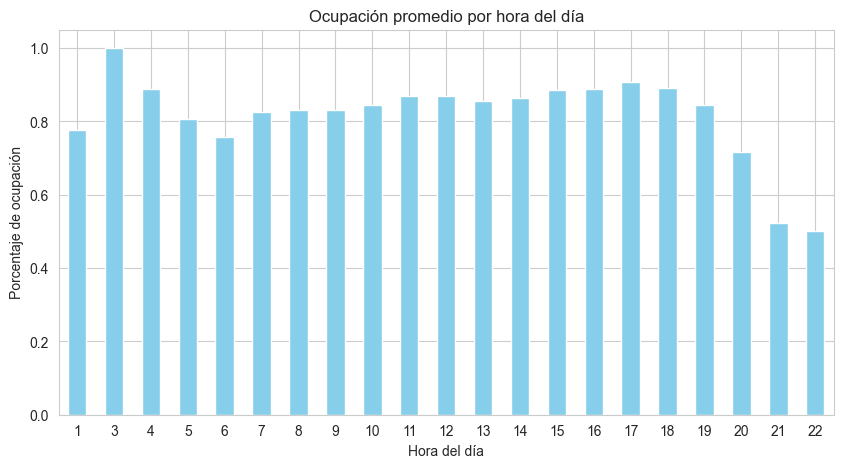

In [178]:
# Gráfico 1: Ocupación promedio por hora del día
plt.figure(figsize=(10,5))
ocupacion_por_hora.plot(kind="bar", color="skyblue")
plt.title("Ocupación promedio por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje de ocupación")
plt.xticks(rotation=0)
plt.show()

#### Ocupación promedio por hora del día → la tarde (16:00–18:00) concentra los viajes con más pasajeros; la noche (21:00–22:00) tiene muy baja ocupación.

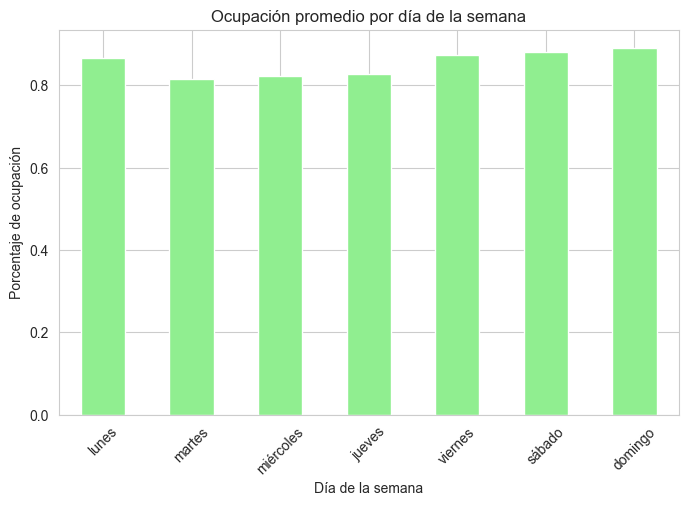

In [179]:
# Gráfico 2: Ocupación promedio por día de la semana
plt.figure(figsize=(8,5))
ocupacion_por_dia_semana = ocupacion_por_dia_semana.reindex(
    ["lunes","martes","miércoles","jueves","viernes","sábado","domingo"]
)
ocupacion_por_dia_semana.plot(kind="bar", color="lightgreen")
plt.title("Ocupación promedio por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Porcentaje de ocupación")
plt.xticks(rotation=45)
plt.show()

#### Ocupación promedio por día de la semana → fines de semana (sábado y domingo) muestran ocupaciones más altas.

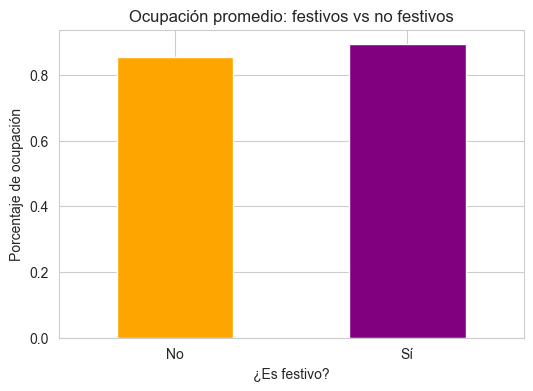

In [180]:
# Gráfico 3: Ocupación en festivos vs no festivos
plt.figure(figsize=(6,4))
ocupacion_festivo.plot(kind="bar", color=["orange","purple"])
plt.title("Ocupación promedio: festivos vs no festivos")
plt.xlabel("¿Es festivo?")
plt.ylabel("Porcentaje de ocupación")
plt.xticks(rotation=0)
plt.show()

#### Ocupación festivos vs no festivos → los festivos suben la demanda respecto a un día normal.

In [181]:
# Paso 3: Relación entre clima y ocupación

# Ocupación promedio por tipo de clima (texto)
ocupacion_por_clima = final_data.groupby("clima")["porcentaje_ocupacion"].mean().sort_values(ascending=False)

# Correlación entre temperatura y ocupación
corr_temp_ocupacion = final_data["temperatura"].corr(final_data["porcentaje_ocupacion"])

ocupacion_por_clima, corr_temp_ocupacion

(clima
 Llovizna ligera                1.000000
 Chubascos ligeros              0.867575
 Nublado                        0.863870
 Despejado                      0.859674
 Principalmente despejado       0.854330
 Parcialmente nublado           0.853700
 Lluvia ligera                  0.851944
 Niebla                         0.846486
 Tormenta eléctrica             0.830361
 Lluvia moderada                0.807540
 Tormenta con granizo ligero    0.790278
 Name: porcentaje_ocupacion, dtype: float64,
 np.float64(0.07277055642829326))

## ✅ Paso 3: Relación entre clima y ocupación

### 📌 Ocupación promedio por tipo de clima

#### Más alta:

- Llovizna ligera → 100% (aunque parece que hay pocos registros, habría que validarlo)
- Chubascos ligeros → 86.8%
- Nublado → 86.4%

#### Más baja:

- Tormenta con granizo ligero → 79.0%
- Lluvia moderada → 80.7%
- Tormenta eléctrica → 83.0%

👉 En general, el mal clima reduce un poco la ocupación, aunque no de forma dramática.

### 📌 Correlación entre temperatura y ocupación

Correlación de 0.073 → muy baja.
👉 Esto indica que la temperatura no influye significativamente en la cantidad de pasajeros.

### ✅ Conclusión:

El clima afecta más por tipo de fenómeno (tormenta, lluvia moderada) que por la temperatura.

Incluso en lluvia ligera o cielo nublado, la gente sigue viajando casi igual que en días despejados.

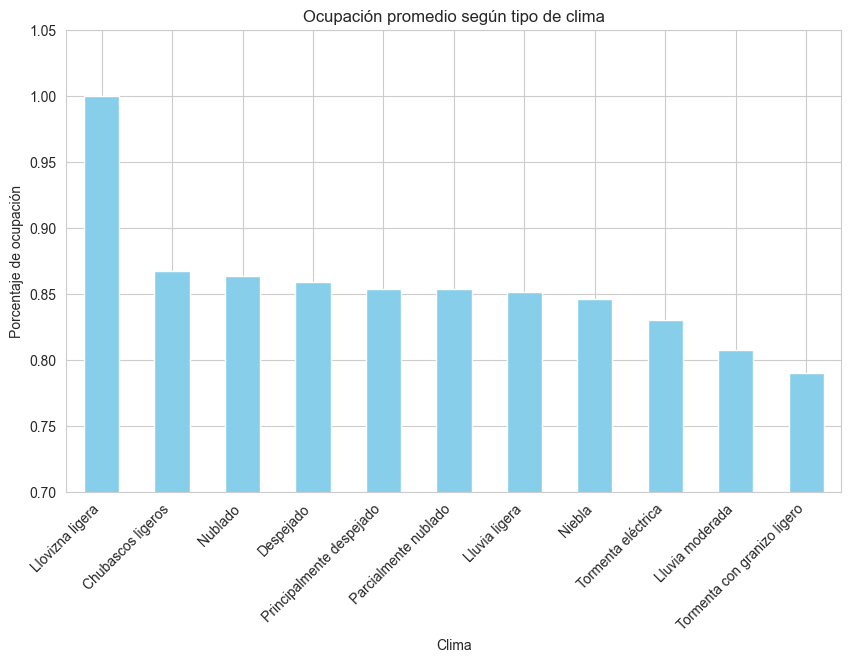

In [182]:
# Gráfico 1: Ocupación promedio por tipo de clima
plt.figure(figsize=(10,6))
ocupacion_por_clima.plot(kind="bar", color="skyblue")
plt.title("Ocupación promedio según tipo de clima")
plt.xlabel("Clima")
plt.ylabel("Porcentaje de ocupación")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.7, 1.05)
plt.show()

### Ocupación promedio según clima → la ocupación se mantiene alta en casi todas las condiciones, pero baja en casos de tormenta y lluvia moderada.

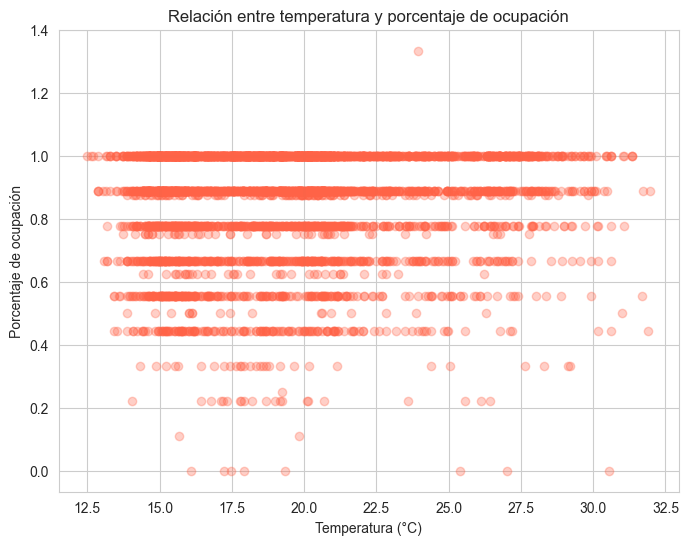

In [183]:
# Gráfico 2: Relación entre temperatura y ocupación (scatter)
plt.figure(figsize=(8,6))
plt.scatter(final_data["temperatura"], final_data["porcentaje_ocupacion"], alpha=0.3, color="tomato")
plt.title("Relación entre temperatura y porcentaje de ocupación")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Porcentaje de ocupación")
plt.show()

### Relación temperatura vs ocupación → la nube de puntos muestra que no hay una relación clara; la ocupación es alta sin importar la temperatura.

## ✅ Paso 4: Conclusiones y recomendaciones para la empresa de transporte 🚍📊

### Tras analizar el dataset final (4630 registros), estos son los hallazgos clave:

### 🔎 Conclusiones

- Alta ocupación promedio:
- Los buses viajan al 85.6% de ocupación promedio.
- En el 75% de los viajes la ocupación está entre 77% y 100%.
- Hay casos de sobrecupo (133%), lo que indica problemas de control de capacidad.

### Patrones temporales:

- La tarde (16:00–18:00) concentra la mayor demanda.
- Los viajes nocturnos (21:00–22:00) tienen ocupaciones muy bajas (50–52%).
- Sábados, domingos y festivos muestran los mayores niveles de ocupación.

### Impacto del clima:

- La temperatura no influye significativamente en la ocupación (correlación 0.07).
- El tipo de clima sí tiene un ligero efecto: en llovizna ligera o nublado la ocupación se mantiene alta, mientras que en tormenta o lluvia moderada baja a ~80%.

### 💡 Recomendaciones

### Gestión de la flota por horarios

- Reducir o reorganizar salidas en noches (21:00–22:00), donde la ocupación cae a la mitad.
- Mantener e incluso reforzar buses en franjas críticas de la tarde y fines de semana.

### Prevención de sobrecupo

- Revisar controles de tiquetes y capacidad máxima (9 pasajeros).
- Implementar alertas de sobreventa para evitar viajes >100% ocupación.

### Gestión en festivos y fines de semana

- Planificar mayor número de buses o refuerzos en esas fechas.
- Ofrecer reservas anticipadas para evitar sobrecupo.

### Comunicación con el pasajero

- Informar a los usuarios sobre horarios de menor ocupación (ej. viajes nocturnos).
- Ofrecer descuentos o promociones en esos horarios para equilibrar la demanda.

## Clima

- Aunque el clima no reduce drásticamente la demanda, en casos de tormenta la ocupación baja. Conviene reforzar la comunicación y seguridad vial en esos contextos.